## Bias correction

The aim is to debias the Climex2 data. ERA5-land is used as a reference here. The ibicus package is used here for bias correcting the data. The debias functions from ibicus require observations, model historical period, model future period. 

Here we are going to use the midday temperature values with the following time periods:
- Observation: ERA5-land  (1991 - 2010)
- Historical: CLIMEX (1991- 2010)
- Future: CLIMEX 20 years to select to bias correct


### User input

The user input required is:
- Future time period (20 years is required, provide start date)
- Bias correcting method
- Ensemble for Climex2 data
- Variable to debias + corresponding path 

In [1]:
import sys
import glob
import xarray as xr
import numpy as np
from dask.distributed import LocalCluster
from ibicus.debias import LinearScaling, DeltaChange, QuantileMapping, CDFt, ISIMIP, ScaledDistributionMapping
import time
import dask.array as da 
import os

In [2]:
t0 = time.time()
baseline_ens = 'hpp'
ens = 'hpp'
bias_correct = 'LS'
start_year = '1991'
end_year = '2010'
var = 'hurs'


In [3]:
# Used for visualisation purposes
#client = LocalCluster().get_client()

2025-03-28 14:30:19,727 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle e9b1d0106b855c9b626c90f3a30ad7a4 initialized by task ('rechunk-merge-rechunk-split-rechunk-transfer-140a4b49ffeaace67e2b863db2e578b7', 0, 4, 5, 0, 6, 7) executed on worker tcp://127.0.0.1:51361
2025-03-28 14:30:19,816 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c66af899508c11efb0c5f8e038b6bf06 initialized by task ('rechunk-merge-rechunk-split-rechunk-transfer-140a4b49ffeaace67e2b863db2e578b7', 0, 3, 4, 0, 4, 6) executed on worker tcp://127.0.0.1:51361
2025-03-28 14:30:19,861 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5cd38325ebaad2d7f876c8cdd1cf3d18 initialized by task ('rechunk-merge-rechunk-split-rechunk-transfer-140a4b49ffeaace67e2b863db2e578b7', 0, 5, 4, 0, 7, 6) executed on worker tcp://127.0.0.1:51361
2025-03-28 14:30:19,907 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b03c00831d4c36561cd02e7bd83c1242 initialized by task ('rechunk-merge-rechunk-trans

In [4]:
#client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51346,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.65 GiB
Comm: tcp://127.0.0.1:51372,Total threads: 3
Dashboard: http://127.0.0.1:51376/status,Memory: 7.91 GiB
Nanny: tcp://127.0.0.1:51349,


### 2. Load files & preprocess data


#### Load climex data - historical (1991 - 2010)

In [5]:
years = np.arange(1991, 2011)
path = "O:/Public/sharing-4270-CERM/VLYMI/CLIMEX2/GlobusDownload/ClimExII_4_Friends/ClimExII_4_Friends/"

files = []

for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'/'+ baseline_ens + '/' + year + '/' + var + '*.nc'))[5:10] # Select only June to October

    

In [6]:
len(files)/5 # Only considering 5months / year

20.0

In [7]:
%%time
ds_hist = xr.open_mfdataset(files)


CPU times: total: 58.1 s
Wall time: 2min 7s


In [8]:
# Select midday timestep
ds_hist = ds_hist.hurs[4:, :, :][::8] 

In [9]:
ds_hist = ds_hist.chunk(chunks={'rlat': 20, 'rlon': 20, 'time': -1})

In [10]:
len(ds_hist.time)

3060

#### Load "observations" - ERA5-land (1991 - 2010)

In [11]:
years = np.arange(1991, 2011)
path = 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/ERA5-land/regrided/FWI-variables/'

files = []

for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'rhum-' + year +'*.nc'))[5:10] # Select only June to October


len(files)/5 # Only considering 5months / year

20.0

In [12]:
%%time
ds_obs = xr.open_mfdataset(files).rhum

CPU times: total: 14.7 s
Wall time: 1min 2s


In [13]:
# Remove leap days 
ds_obs = ds_obs.sel(time = ~((ds_obs.time.dt.month == 2) & (ds_obs.time.dt.day == 29)))
ds_obs = ds_obs.chunk(chunks={'y': 20, 'x': 20, 'time': -1})

In [14]:
len(ds_obs.time)

3060

### 3. Future data to bias correct: Select 20 year period

In [15]:
years = np.arange(int(start_year), int(end_year) + 1)
path = "O:/Public/sharing-4270-CERM/VLYMI/CLIMEX2/GlobusDownload/ClimExII_4_Friends/ClimExII_4_Friends/"

files = []

for year in years:
    year = str(year)
    files = files + sorted(glob.glob(path +'/' + ens + '/' + year + '/' + var + '_' + ens + '*.nc'))[5:10] # Select only June to October

In [16]:
len(files)/5

20.0

In [17]:
%%time
ds_fut = xr.open_mfdataset(files)


CPU times: total: 41.9 s
Wall time: 1min 13s


In [18]:
# Select midday timestep
ds_fut = ds_fut.hurs[4:, :, :][::8] 

In [19]:
ds_fut = ds_fut.chunk(chunks={'rlat': 20, 'rlon': 20, 'time': -1})

In [20]:
len(ds_fut.time)

3060

### 4. Debias data

Ibicus has an option to use dask to apply the debiaser which makes it possible to bias correct the data in Europe for a 20 year period. 

In [21]:
if bias_correct == 'QM':
    debiaser = QuantileMapping.from_variable(variable = var)
elif bias_correct == 'LS':
    debiaser = LinearScaling.from_variable(variable = var)
elif bias_correct == 'SDM':
    debiaser = ScaledDistributionMapping.from_variable(variable = var)
elif bias_correct == 'ISIMIP':
    debiaser = ISIMIP.from_variable(variable = var)
else:
    print('Not available. Options available are QM, LS, DC or SDM')
    

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\ibicus\debias\_linear_scaling.py:112: UserWarning: The default settings for variable hurs in debiaser LinearScaling are currently still experimental and may not have been evaluated in the peer-reviewed literature. Please review the results with care!
  return super()._from_variable(


In [22]:
%%time 
collection = da.map_blocks(debiaser.apply, ds_obs.data, ds_hist.data, ds_fut.data, dtype=ds_obs.dtype, progressbar = False, parallel = False, failsafe = True)
debiased_cm_future = collection.compute(num_workers=8)

CPU times: total: 1min 24s
Wall time: 4min 30s


### 5. Save data

In [23]:
# Create folder to save data to 
save_path = 'O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/CLIMEX2/debiased/' + var + '/'+ ens + '/'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [24]:
ds_fut_new = ds_fut.copy()
ds_fut_debias = ds_fut_new.to_dataset()
ds_fut_debias = ds_fut_debias.drop_vars(var)
ds_fut_debias = ds_fut_debias.assign(rhum = (['time', 'rlat', 'rlon'], debiased_cm_future))
ds_fut_debias.to_netcdf(save_path + var + '_' + start_year + '-' + end_year + '_' + bias_correct +'.nc')

In [25]:
t1 = time.time()
print((t1 - t0)/60)

12.62163867155711


In [26]:
fut = ds_fut_debias.rhum.values

In [27]:
hist = ds_hist.values

In [28]:
hist[np.isnan(fut)] = np.nan

In [29]:
obs = ds_obs.values

C:\Users\ophme\AppData\Local\Temp\ipykernel_22872\1287910128.py:3: RuntimeWarning: Mean of empty slice
  ax.pcolor(np.nanmean(hist, axis = 0) - np.nanmean(obs, axis = 0), vmin = -10, vmax = 10, cmap = 'bwr' )


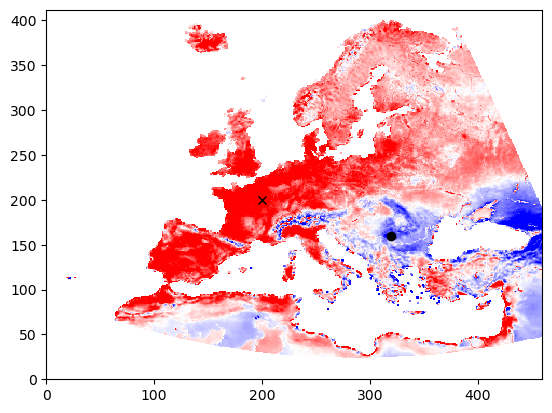

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pcolor(np.nanmean(hist, axis = 0) - np.nanmean(obs, axis = 0), vmin = -10, vmax = 10, cmap = 'bwr' )
ax.plot(200, 200, 'kx')
ax.plot(320, 160, 'ko')

Text(0.5, 1.0, 'location o')

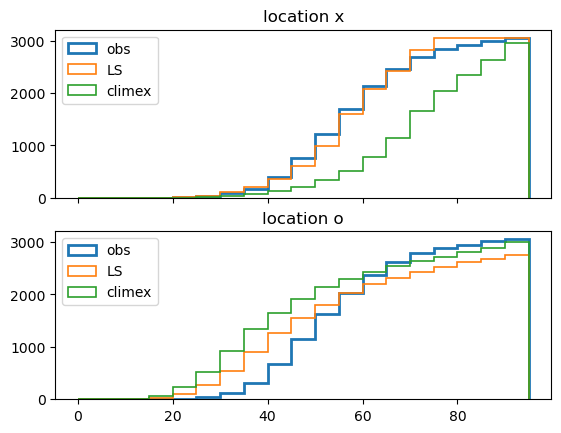

In [31]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].hist(obs[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = 'obs', lw = 2, cumulative=True)
ax[0].hist(fut[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = bias_correct, lw = 1.2, cumulative=True)
ax[0].hist(hist[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = 'climex', lw = 1.2, cumulative=True)
ax[0].legend()
ax[0].set_title('location x')

ax[1].hist(obs[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = 'obs', lw = 2, cumulative=True)
ax[1].hist(fut[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = bias_correct, lw = 1.2, cumulative=True)
ax[1].hist(hist[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = 'climex', lw = 1.2, cumulative=True)
ax[1].legend()
ax[1].set_title('location o')


Text(0.5, 1.0, 'location o')

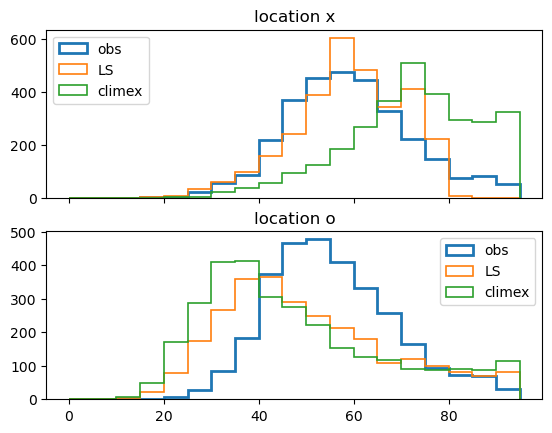

In [32]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].hist(obs[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = 'obs', lw = 2)
ax[0].hist(fut[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = bias_correct, lw = 1.2)
ax[0].hist(hist[:, 200, 200], bins = np.arange(0, 100, 5), histtype='step', label = 'climex', lw = 1.2)
ax[0].legend()
ax[0].set_title('location x')

ax[1].hist(obs[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = 'obs', lw = 2)
ax[1].hist(fut[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = bias_correct, lw = 1.2)
ax[1].hist(hist[:, 160, 320], bins = np.arange(0, 100, 5), histtype='step', label = 'climex', lw = 1.2)
ax[1].legend()
ax[1].set_title('location o')

(0.0, 154.0)

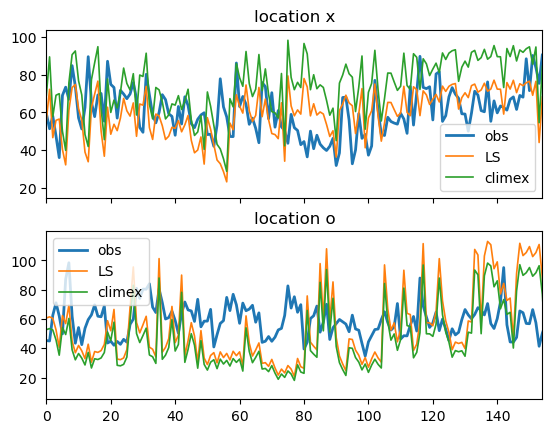

In [33]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(obs[:, 200, 200], label = 'obs', lw = 2)
ax[0].plot(fut[:, 200, 200], label = bias_correct, lw = 1.2)
ax[0].plot(hist[:, 200, 200], label = 'climex', lw = 1.2)
ax[0].legend()
ax[0].set_title('location x')

ax[1].plot(obs[:, 160, 320], label = 'obs', lw = 2)
ax[1].plot(fut[:, 160, 320], label = bias_correct, lw = 1.2)
ax[1].plot(hist[:, 160, 320], label = 'climex', lw = 1.2)
ax[1].legend()
ax[1].set_title('location o')
ax[0].set_xlim(0, 154)

Text(0.5, 1.0, 'QM - obs')

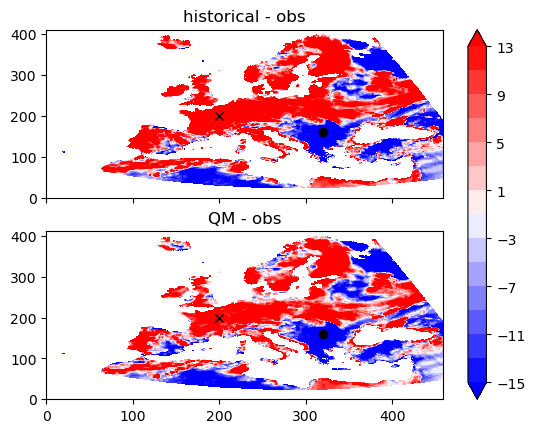

In [34]:
day = 100
fig, ax = plt.subplots(2, 1, sharex = True)
a = ax[0].contourf(hist[day, :, :] - obs[day, :, :] , levels = np.arange(-15, 14, 2), cmap = 'bwr', extend = 'both' )
ax[0].plot(200, 200, 'kx')
ax[0].plot(320, 160, 'ko')
ax[1].contourf(fut[day, :, :] - obs[day, :, :] , levels = np.arange(-15, 14, 2), cmap = 'bwr', extend = 'both' )
ax[1].plot(200, 200, 'kx')
ax[1].plot(320, 160, 'ko')
fig.colorbar(a, ax = ax[:])
ax[0].set_title('historical - obs')
ax[1].set_title('QM - obs')


In [35]:
print(np.nanmean(obs[:, 200, 200]))
print(np.nanmean(hist[:, 200, 200]))
print(np.nanmean(fut[:, 200, 200]))

59.19613679000755
73.252396
59.19614


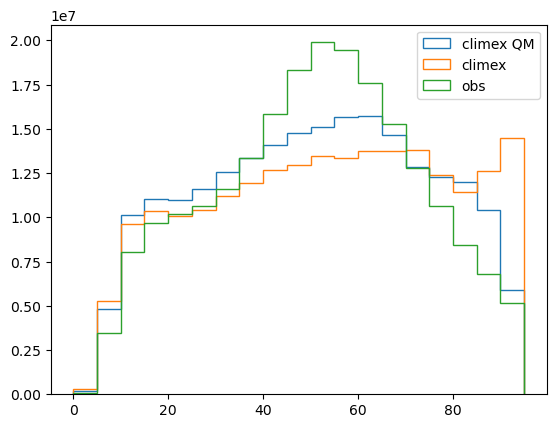

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(debiased_cm_future.flatten(), bins = np.arange(0, 100, 5), histtype='step', label = 'climex QM')
ax.hist(hist.flatten(), bins = np.arange(0, 100, 5), histtype='step', label = 'climex')
ax.hist(obs.flatten(), bins = np.arange(0, 100, 5), histtype='step', label = 'obs')
ax.legend()

In [ ]:
exit()